# GTFS Datasets
### Calendar Dates
Exceptions for the service IDs defined in the calendar.txt file. If calendar_dates.txt includes ALL dates of service, this file may be specified instead of calendar.txt. Note: There is no calendar.txt in the GTFS zip provided by the API.
### Routes
Transit routes. A route is a group of trips that are displayed to riders as a single service.
### Shapes
Rules for drawing lines on a map to represent a transit organization's routes.
### Stop Times
Times that a vehicle arrives at and departs from individual stops for each trip.
### Stops
Individual locations where vehicles pick up or drop off passengers.
### Trips
Trips for each route. A trip is a sequence of two or more stops that occurs at specific time.


In [9]:
import src.GTFS as GTFS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, requests, zipfile, io
from datetime import timedelta, datetime
from bisect import bisect
from collections import defaultdict
from shutil import rmtree
from matplotlib import dates


gtfs = GTFS.GTFS()
assert gtfs.get_current_source_url() == "https://storage.googleapis.com/storage/v1/b/mdb-latest/o/us-new-jersey-new-jersey-transit-nj-transit-gtfs-508.zip?alt=media"


/Users/laurasoares/Documents/NJTransit/Internship 2023/ZEB/02 Analysis/PythonNotebook/src/GTFS.py:77: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  self.stop_times = pd.read_csv("gtfs/stop_times.txt", parse_dates=TIME_COLS, date_parser=parse_dates)


# Analysis: Wayne Trips
We want to create a dataset that contains the following information for Wayne trips

### Grain:
Trip
### Unique column set: 
trip_id
### Dimensions: 
route_id, block_id, service_id, shape_id
### Additive Facts: 
departure_time, arrival_time, duration
### Non-additive Facts: 
route_short_name, trip_headsign

This datset will contain information about trips going to and from the Wayne Garage. Theoretically, all of these trips should either be going to or coming from the Port Authority in NY. Trips are linked by their service_id-block_id combination. One service_id-block_id combination indicates a sequence of trips performed by one bus.

We need to perform the following tasks:
- Calculate how long each bus waits at the terminal between trips
- Determine which trips have ended at Port Authority
- Calculate how many buses are waiting at the Terminal between trips for a given unit of time

We will verify which trips terminate at Port Authority by using the GTFS stop_times dataset, which we will discuss below.

In [30]:
"""
Step 1: Calculate how long each bus waits at the terminal between trips
Filter for trips from Wayne garage
"""
#Join TRIPS onto ROUTEs to get trip_id, min_arrival_time, max_departure_time, route_short_name, etc...
trip_routes = gtfs.trips.merge(gtfs.routes[["route_id", "route_short_name"]], on="route_id")

# Get just the trips that refer to Wayne
wayne_trips = trip_routes[trip_routes.block_id.str.contains("WY") == True]
wayne_trips = gtfs.add_trip_next_arrival_time(wayne_trips)

# There are some instances where the next arrival time is less than departure, remove the block_id-service_id combinations where this happens
bad_block_services = wayne_trips[wayne_trips.next_arrival_time < wayne_trips.final_departure_time][GTFS.LINKED_TRIP_GROUPS]

# Perform anti-join to remove these block_id-service_id combinations
wayne_trips = wayne_trips.merge(bad_block_services, how="left", on=GTFS.LINKED_TRIP_GROUPS, indicator=True)
wayne_trips = wayne_trips[wayne_trips._merge == "left_only"].drop(axis="columns", labels="_merge")
wayne_trips.time_waiting.describe()


count                         1369
mean     0 days 00:36:33.265157048
std      0 days 00:34:28.741160428
min                0 days 00:05:00
25%                0 days 00:19:00
50%                0 days 00:27:00
75%                0 days 00:39:00
max                0 days 06:25:00
Name: time_waiting, dtype: object

In [31]:
"""
Step 2: Determine which trips are ending at Port Authority (the last stop in the stop_sequence is a Port Authority stop)
"""
# Determine which stops are Port Authority stops
port_authority_stops = gtfs.stops[gtfs.stops.stop_name.str.contains("PORT AUTHORITY")]["stop_id"].tolist()

# Add indicator variable to the wayne_trips dataset
wayne_trips["is_port_authority_stop"] = wayne_trips.final_stop_id.apply(lambda x: 1 if x in port_authority_stops else 0)

# Create new dataset that has wayne trips where final stop is Port Authority
wayne_to_PA_trips = wayne_trips[wayne_trips.is_port_authority_stop == 1]

# How many of the Wayne trips have final stop at Port Authority?
print("Percentage of Wayne trips w/ final stop at Port Authority: {:2.2%}".format(wayne_to_PA_trips.shape[0] / wayne_trips.shape[0]))


Percentage of Wayne trips w/ final stop at Port Authority: 50.91%


In [32]:
# Read in the Wayne block predicted completion table
wayne_block_preds = pd.read_csv("datasets/wayne_block_predictions.csv", 
                                usecols=["Block", "No_ Complete_100", "Complete_99",	"Complete_95",	"Complete_90"])

# Rename the columns to reflect their actual meaning
wayne_block_preds = wayne_block_preds.rename({"Block": "block_id",
                                              "No_ Complete_100": "is_incomplete_100th",
                                              "Complete_99": "is_incomplete_99th", 
                                              "Complete_95": "is_incomplete_95th", 
                                              "Complete_90": "is_incomplete_90th"}, axis=1)

# Remove duplicates
wayne_block_preds = wayne_block_preds.groupby("block_id").max().reset_index()

# Join on wayne_trips
wayne_trip_preds = wayne_to_PA_trips.merge(wayne_block_preds, on="block_id", how="left")
assert wayne_trip_preds.shape[0] == wayne_to_PA_trips.shape[0]

# Fill missing values with 1
percentile_columns = wayne_block_preds.columns[1:].tolist()
wayne_trip_preds[percentile_columns] = wayne_trip_preds[percentile_columns].fillna(1)
wayne_trip_preds.describe()


,route_id,service_id,trip_id,direction_id,shape_id,final_departure_time,final_stop_id,first_arrival_time,duration,next_arrival_time,time_waiting,is_port_authority_stop,is_incomplete_100th,is_incomplete_99th,is_incomplete_95th,is_incomplete_90th
count,1153.000000,1153.000000,1153.000000,1153.0,1153.000000,1153,1153.0,1153,1153,828,828,1153.0,1153.000000,1153.000000,1153.000000,1153.000000
mean,60.010408,3.300954,11514.124892,0.0,964.552472,0 days 13:06:48.395490026,43274.0,0 days 12:01:40.797918473,0 days 01:05:07.597571552,0 days 14:43:42.753623188,0 days 00:36:17.971014492,1.0,0.709454,0.703382,0.611448,0.554206
std,11.956587,1.467403,2539.776868,0.0,264.090047,0 days 05:33:38.359063456,0.0,0 days 05:27:12.997487266,0 days 00:18:44.404721085,0 days 05:40:27.372089866,0 days 00:38:30.682984326,0.0,0.454212,0.456965,0.487633,0.497269
min,16.000000,1.000000,2831.000000,0.0,262.000000,0 days 05:08:00,43274.0,0 days 04:14:00,0 days 00:29:00,0 days 05:20:00,0 days 00:09:00,1.0,0.000000,0.000000,0.000000,0.000000
25%,46.000000,2.000000,8397.000000,0.0,622.000000,0 days 08:14:00,43274.0,0 days 07:20:00,0 days 00:54:00,0 days 09:14:30,0 days 00:19:00,1.0,0.000000,0.000000,0.000000,0.000000
50%,63.000000,4.000000,12589.000000,0.0,1053.000000,0 days 11:34:00,43274.0,0 days 10:23:00,0 days 01:03:00,0 days 14:55:00,0 days 00:26:00,1.0,1.000000,1.000000,1.000000,1.000000
75%,66.000000,5.000000,13256.000000,0.0,1150.000000,0 days 17:40:00,43274.0,0 days 16:20:00,0 days 01:18:00,0 days 19:30:00,0 days 00:37:00,1.0,1.000000,1.000000,1.000000,1.000000
max,95.000000,7.000000,17392.000000,0.0,1566.000000,1 days 03:36:00,43274.0,1 days 02:30:00,0 days 02:18:00,1 days 04:00:00,0 days 06:25:00,1.0,1.000000,1.000000,1.000000,1.000000


In [33]:
"""
Step 3: Calculate how many buses are waiting at the Terminal between trips for a given unit of time
"""
# Nice DataFrame showing Time interval & num buses
interval_buses = add_interval_counts_wrapper(wayne_trip_preds)

# This gets the number of buses waiting at terminal for each interval, grouped by service_id
service_groups = wayne_trip_preds.groupby(["service_id", "is_incomplete_99th"])
service_interval_buses = service_groups.apply(add_interval_counts_wrapper).reset_index(level=(0, 1))

# Convert the interval to a datetime from timedelta
service_interval_buses["date_interval"] = service_interval_buses.interval.apply(lambda x: datetime.strptime(str(x), "%H:%M:%S"))

# Sort by the interval
service_interval_buses = service_interval_buses.sort_values(by="date_interval")

# For matplotlib formatting purposes convert to float
service_interval_buses["date2num"] = service_interval_buses.date_interval.apply(lambda x: dates.date2num(x))

# To get a stacked chart showing num complete & num incomplete buses for service id and time interval
gb = service_interval_buses.groupby(["service_id", "interval", "date_interval", "date2num"])
incomplete_buses = gb.apply(lambda x: x[x.is_incomplete_99th == 1].num_buses.sum()).rename("num_incomplete_buses")
complete_buses = gb.apply(lambda x: x[x.is_incomplete_99th == 0].num_buses.sum()).rename("num_complete_buses")
stackplot_df = pd.concat([incomplete_buses, complete_buses], axis=1).reset_index()
stackplot_df.head()


,service_id,interval,date_interval,date2num,num_incomplete_buses,num_complete_buses
0,1,10:00:00,1900-01-01 10:00:00,-25566.583333,11,2
1,1,10:15:00,1900-01-01 10:15:00,-25566.572917,9,1
2,1,10:30:00,1900-01-01 10:30:00,-25566.562500,10,1
3,1,10:45:00,1900-01-01 10:45:00,-25566.552083,9,1
4,1,11:00:00,1900-01-01 11:00:00,-25566.541667,9,1


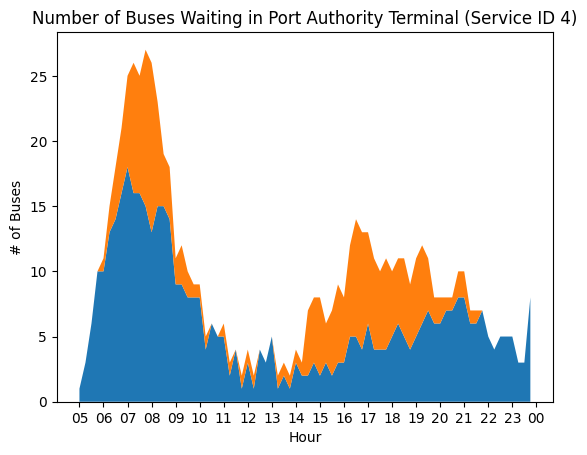

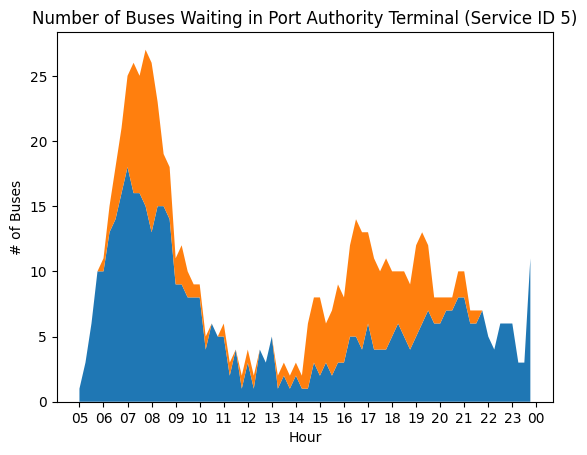

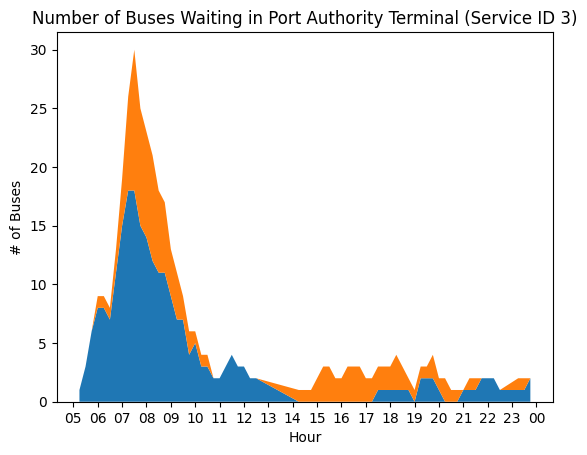

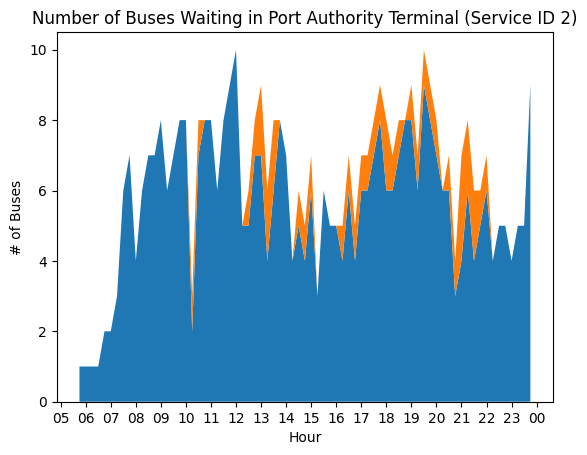

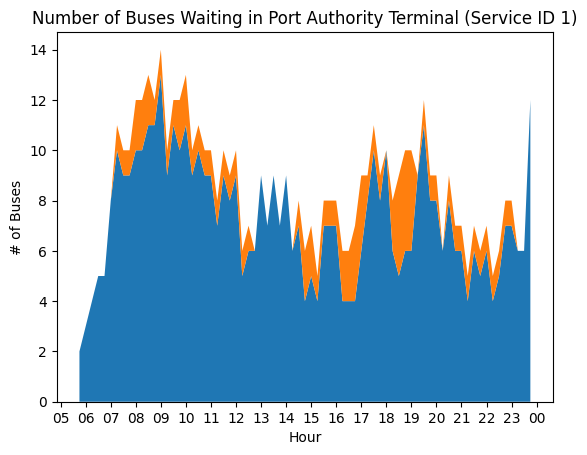

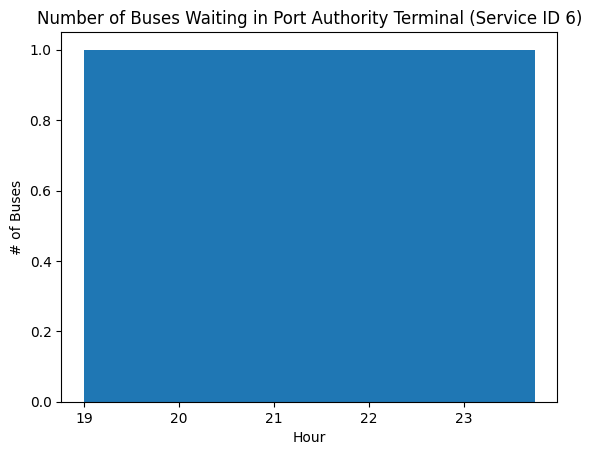

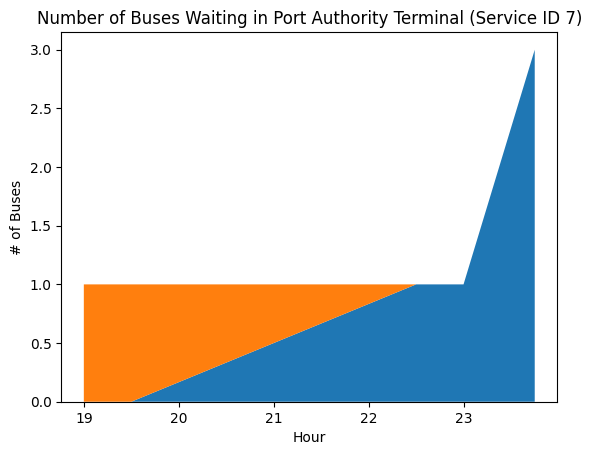

In [35]:
def create_stack_plot(df, service_id, x, *y):
    """
    Creates a stackplot where the x-axis ticks should be an hour and x is numerical representation of datetime

    Optional filtering on service_id
    """
    df = df[df.service_id == service_id].sort_values(by="date_interval")
    title = f"Number of Buses Waiting in Port Authority Terminal (Service ID {service_id})"
    ax = plt.gca()
    ax.clear()
    ax.xaxis.set_major_locator(dates.HourLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H'))
    
    plt.stackplot(df[x], *[df[col] for col in y])
    plt.ylabel("# of Buses")
    plt.xlabel("Hour")
    plt.title(title)
    plt.show()


for service_id in service_interval_buses.service_id.unique():
    create_stack_plot(stackplot_df, service_id, "date2num", "num_incomplete_buses", "num_complete_buses")
